<center>
<h1>Mustererkennung und Machine Learning</h1>

<h3> Wintersemester 2017/2018, 3rd Exercise Sheet</h3>
<h4>Luis Herrmann; Dozent: Raúl Rojas</h4>

<hr style='height:1px'>
</center>

First of all, we define the functions to load the data form the specified files. Please sure to change the path for the training files for the respective path.

In [8]:
%matplotlib inline
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def readfile(filename):
    """Opens file with given filename and reads in data line after line into a numpy array"""
    data = []
    f = open(filename)
    for line in f:
        ls = line.split(' ')
        digit = int(float(ls[0]))
        matrix = np.array([float(val) for val in ls[1:257]])
        data.append((digit,matrix))
    f.close()
    return(data)
    
def visualize(data,i):
    """
    For a list of numpy arrays with 256 greyscale values, visualizes the greyscale data 
    creating a greyscale plot of the reshaped 16x16 numpy array
    """
    plt.gray()
    plt.imshow(data[i][1].reshape([16,16]))
    
train = readfile('E:/Users/Tanui/Documents/Uni/info/MachineLearning/zip.train')
test = readfile('E:/Users/Tanui/Documents/Uni/info/MachineLearning/zip.test')

To make sure that our data makes sense, we visualize the greyscale data vector for our first data sample of the training data.

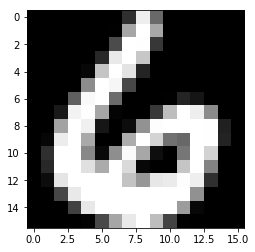

In [9]:
visualize(train,0)

Now we shall implement a classifier using  a gaussian multivariate distribution. For such a distribution, the probability is given by:

<center>$p(\vec{x}) = \frac{1}{\sqrt{(2\pi)^{n} \det(\Sigma)}} \exp\left(-\frac{1}{2} (\vec{x} - \vec{\mu})^T \Sigma^{-1} (\vec{x} - \vec{\mu}) \right)$</center>

Where $n$ is the dimension of the multivariate distribution, $\Sigma$ is the so-called covariance matrix and $\vec{\mu}$ the mean vector. Given a set of training vectors $\vec{v_1}, \vec{v_2}, ... \vec{v_N}$, the latter are determined as:

<center>$\Sigma := \frac{1}{N}\sum_i^N (\vec{x}_i - \vec{\mu})(\vec{x}_i - \vec{\mu})^T \qquad \vec{\mu} := \frac{1}{N} \sum_i^N \vec{x}_i$</center>

So the idea is the following: Use a set of training vectors to compute a Gaussian distribution for each digit class describing the probability that a vector $\vec{x}$ belongs to that class.
After that, given a vector $\vec{x}$ that we want to assign to one of the classes of our respective classifier, calculate the probability $p_d(\vec{x})$ for all digit classes $d$ considered by the classifier and assign $\vec{x}$ to the digit class $d$ for which $p_d(\vec{x})$ is greatest.

In [50]:
class GaussianClassifier:
    def __init__(self, digits, data=None):
        """Expects data and two nonequal ints betweeen 0 and 9 specifying the class of the classifier"""
        self.digits = []
        digitsOccurence = [0]*10
        for digit in digits:
            if(not(0 <= digit and digit <= 9)):
                raise Exeption('The digits passed must be an int between 0 and 9!')
            if(digitsOccurence[digit] == 1):
                print('Multiple occurence of digit class ' + str(digit) + ' will be ignored..')
            else:
                self.digits.append(digit)
                digitsOccurence[digit] = 1
        if(sum(digitsOccurence) < 2):
            raise Exception('You must pass at least two different digit classes!')
        if(data != None):
            self.train(data)
        
    def train(self, trainData):
        """
        Expects a list of [d,v], where v is a data vector and d the assigned digit class and trains
        by calculating the parameters of the corresponding multivariate gaussian distributions p_c(x).
        """
        #Extracting of data belonging to registered digits
        digitData = {}
        for sample in trainData:
            if(sample[0] in self.digits):
                if(sample[0] in digitData):
                    digitData[sample[0]].append(np.reshape(sample[1], [256,1]))
                else:
                    digitData[sample[0]] = [np.reshape(sample[1], [256,1])]
        print('Filtering of data complete.')
        #Calculate the parameters of p_c(x) for each digit class 
        self.params = {}
        for key in digitData:
            mu = sum(digitData[key])/len(digitData[key])
            Sigma = sum([np.dot(x-mu,np.transpose(x-mu)) for x in digitData[key]])/len(digitData[key])
            fac = 1e-1
            step = fac*np.identity(256)
            while(np.linalg.det(Sigma) == 0):
                Sigma += step
            norm = 1/np.sqrt((2*np.pi)**256 * np.linalg.det(Sigma))
            Sigmai = -1/2*np.linalg.inv(Sigma)
            self.params[key] = (norm, mu, Sigmai)
        print('Completed training on ' + str(sum([len(digitData[k]) for k in digitData])) + ' data samples.')
    
    def reduce(self, data):
        """Keeps only data samples corresponding to the two digits of the class"""
        filteredData = []
        for sample in data:
            if(sample[0] in self.digits):
                filteredData.append(sample)
        return filteredData
        
    def classify(self, data):
        """
        Expects a vector of dimension 256.
        Returns digit, for which the probability is greatest assuming a gaussian multivariate distribution
        """ 
        def gaussian(digit,x):
            norm, mu, Sigmai = self.params[digit]
            return norm*np.exp(np.dot(np.transpose(x-mu),np.dot(Sigmai,x-mu)))
        
        return max(self.digits, key=lambda x: gaussian(x, np.reshape(data, [256,1])))

With the classifier defined, we derive six different classifiers for the respective digits:

In [45]:
C35 = GaussianClassifier([3, 5], train)
C37 = GaussianClassifier([3, 7], train)
C38 = GaussianClassifier([3, 8], train)
C57 = GaussianClassifier([5, 7], train)
C58 = GaussianClassifier([5, 8], train)
C78 = GaussianClassifier([7, 8], train)

Filtering of data complete.
Completed training on 1214 data samples.
Filtering of data complete.
Completed training on 1303 data samples.
Filtering of data complete.
Completed training on 1200 data samples.
Filtering of data complete.
Completed training on 1201 data samples.
Filtering of data complete.
Completed training on 1098 data samples.
Filtering of data complete.
Completed training on 1187 data samples.


Finally, we define a function runtest to run the <font color='blue'>classifer()</font>-functions of the respective classifier on the test data and obtain the confusion matrices and error rates

In [46]:
from IPython.display import display, HTML
def runtest(C):
    index= {}
    for i in range(len(C.digits)):
        index[C.digits[i]] = i
    print('Test for Classifier for digits ' + ', '.join([str(x) for x in C.digits[:-1]]) + ' and ' + str(C.digits[-1]) + ':')
    ftest = C.reduce(test)
    confusionMat = np.zeros([len(C.digits), len(C.digits)], dtype=int)
    for sample in ftest:
        confusionMat[index[sample[0]], index[C.classify(sample[1])]] += 1
    print('-The confusion matrix is given by:')
    html = pd.DataFrame(confusionMat,index=[str(x) for x in C.digits], columns=[str(x) for x in C.digits]).to_html()
    display(HTML(html))
    print('-The error rate is: ' + str(1-sum(np.diag(confusionMat))/len(ftest)) + '\n')

In [47]:
runtest(C35)
runtest(C37)
runtest(C38)
runtest(C57)
runtest(C58)
runtest(C78)

Test for Classifier for digits 3 and 5:
-The confusion matrix is given by:


,3,5
3,153,13
5,4,156


-The error rate is: 0.0521472392638

Test for Classifier for digits 3 and 7:
-The confusion matrix is given by:


,3,7
3,166,0
7,2,145


-The error rate is: 0.00638977635783

Test for Classifier for digits 3 and 8:
-The confusion matrix is given by:


,3,8
3,160,6
8,6,160


-The error rate is: 0.0361445783133

Test for Classifier for digits 5 and 7:
-The confusion matrix is given by:


,5,7
5,159,1
7,2,145


-The error rate is: 0.00977198697068

Test for Classifier for digits 5 and 8:
-The confusion matrix is given by:


,5,8
5,154,6
8,6,160


-The error rate is: 0.0368098159509

Test for Classifier for digits 7 and 8:
-The confusion matrix is given by:


,7,8
7,143,4
8,0,166


-The error rate is: 0.0127795527157



Finally, we try out the classifier for all classes:

In [48]:
C3578 = GaussianClassifier([3, 5, 7, 8], train)
runtest(C3578)

Filtering of data complete.
Completed training on 2401 data samples.
Test for Classifier for digits 3, 5, 7 and 8:
-The confusion matrix is given by:


,3,5,7,8
3,150,11,0,5
5,4,150,1,5
7,1,1,142,3
8,6,3,0,157


-The error rate is: 0.0625978090767

